# Extracting edge level noise features 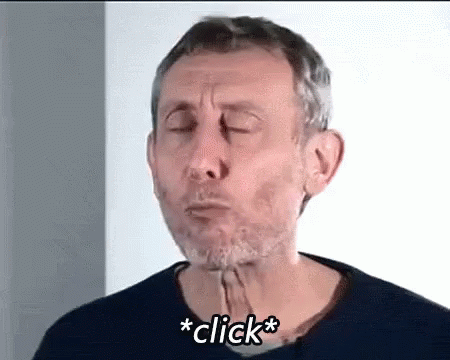
This notebook details the process of extracting edge level noise features. It builds upon [`experimental/noise.ipynb`](/notebooks/experimental/birds.ipynb) & [`experimental/classifying_edges.ipynb`]('(/notebooks/experimental/classifying_edges.ipynb)'). It contains:

- Data
- Processing
- Exporting data

In [3]:
import pandas as pd
import ast

import geopandas as gpd
import contextily as cx
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt 

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


#### Getting noise values on each edge (road) is a two-step job: 
- The noise data comes with a geometry of polygons, and the edges are linestrings, so the linestrings have to be mapped to the nearest polygon(s). However, the noise data only has information from Copenhagen municipality. 

- Frederiksberg, as well as some roads which not get mapped, are lacking these noise values. To overcome this, we implement a simple RandomForestRegressor to hopefully learn some characteristics about the data, that can be used to predict the noise value from the roads that lack the noise feature. 

## Mapping linestrings to nearest polygons

### Data

The original noise data is visualized here: https://www.kk.dk/borger/affald-og-miljoe/stoej-stoev-og-luft/trafikstoej

The data is aquired from https://www.opendata.dk/city-of-copenhagen/vejstoej_2022 where the chosen dataset is the Nord2000. The reason for choosing Nord2000 over CNOSSOS is that "Miljøstyrelsen" ("The Danish Environmental Protection Agency") says the following:

*CNOSSOS er en simplere og overordnet set mindre nøjagtig model end den vi anvender i Danmark, nemlig beregningsmodellen Nord2000.*

This is roughly translated to:
*CNOSSOS is a simpler, and over all, less accurate model than the one we use in Denmark, namely the Nord2000 model of calculation.*

In [6]:
# Reading the data
gdf_noise = gpd.read_file('../data/raw/stoej.json')
gdf_roads = gpd.read_file('../data/raw/edges.json')

KeyboardInterrupt: 

Since this data is located in Denmark, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [ ]:
# Casting to new epsg in order to use meters in the buffer zone
gdf_noise = gdf_noise.to_crs(epsg=25832)
gdf_roads = gdf_roads.to_crs(epsg=25832)

In [ ]:
# Buffer the roads
gdf_roads['geometry'] = gdf_roads.geometry.buffer(10)

In [ ]:
# Create a spatial index for the noise polygons
noise_sindex = gdf_noise.sindex

In [ ]:
# Intersect buffered roads with noise polygons using the spatial index and store intersection results
intersection_results = []
for road in tqdm(gdf_roads.itertuples(), total=len(gdf_roads), desc='Processing roads'):
    possible_matches_i = list(noise_sindex.intersection(road.geometry.bounds))
    possible_matches = gdf_noise.iloc[possible_matches_i]

    road_area = road.geometry.area
    for noise_polygon in possible_matches.itertuples():
        if road.geometry.intersects(noise_polygon.geometry):
            intersection = road.geometry.intersection(noise_polygon.geometry)
            
            if not intersection.is_empty:
                intersection_area = intersection.area

                intersection_results.append({
                    'road_id': road.id,
                    'road_length': road.geometry.length,
                    'noise_id': noise_polygon.id,
                    'intersection_area': intersection_area,
                    'road_area': road_area,
                    'noise_level': noise_polygon.isov1
                })

In [7]:
# Convert the intersection results to a DataFrame
intersections_df = pd.DataFrame(intersection_results)

NameError: name 'intersection_results' is not defined

In [ ]:
# Calculate the total intersection area for each road by summing up 
# the intersection areas of all noise polygons that intersect with the road.
intersection_sums = intersections_df.groupby('road_id')['intersection_area'].sum().reset_index()
intersection_sums.rename(columns={'intersection_area': 'total_intersection_area'}, inplace=True)


In [ ]:
# Merge to get the total intersection area per road
intersections_df = intersections_df.merge(intersection_sums, on='road_id')

In [ ]:
# Calculate normalized intersection percentage
intersections_df['intersection_percentage'] = intersections_df['intersection_area'] / intersections_df['total_intersection_area']

In [ ]:
#Calculate weighted noise based on normalized intersection percentage
intersections_df['weighted_noise'] = intersections_df['noise_level'] * intersections_df['intersection_percentage']

In [ ]:
# Group by road id to sum the weighted noise levels
road_noise = intersections_df.groupby('road_id')['weighted_noise'].sum().reset_index()

In [ ]:
# Merge the noise information back to the original road dataset
gdf_roads['id'] = gdf_roads['id'].astype(str)  # Ensuring 'id' is of the same data type
road_noise['road_id'] = road_noise['road_id'].astype(str)  # Ensuring 'road_id' is of the same data type
gdf_roads = gdf_roads.merge(road_noise, left_on='id', right_on='road_id', how='left').drop(columns=['road_id'])

In [8]:
#Ensure the new 'weighted_noise' does not have NaNs (Frederiksberg data or none mapped linestrings)
gdf_roads['weighted_noise'] = gdf_roads['weighted_noise'].fillna(0)

NameError: name 'gdf_roads' is not defined